In [378]:
# CARGAMOS LIBRERIAS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import datetime

import boto3
import s3fs
import fastparquet
import awswrangler as wr
import os

import pyarrow.parquet as pq
import pyarrow as pa

import requests
import json
from io import BytesIO

DETALLE DE LAS ACCIONES DE ESTE NOTEBOOK:
- SE CARGAN LOS DATOS DE COMPOSICIÓN HISTORICA DEL IBEX35
- SE DESCARGAN LOS DATOS DE CADA ACTIVO EN CADA UNA DE LAS FECHAS CORRESPONDIENTES UTILIZANDO LA API DE MARKETSTACK
- SE CARGAN LOS DATOS EN FICHEROS DE FORMATO PARQUET EN UN BUCKET DE S3
- SE CONSUMEN LOS DATOS DESDE EL BUCKET DE S3 Y SE GENERA UN SOLO DATAFRAME CON LOS DATOS DEL CIERRE AJUSTADO PARA TODOS LOS ACTIVOS
- SE CALCULAN LOS RETORNOS Y OTRAS MÉTRICAS DE INTERÉS PARA TODOS LOS ACTIVOS
- SE GENERA UN RANKING PARA CADA DÍA EN BASE A UNA MÉTRICA SELECCIONADA
- SE 

## CARGA DE COMPOSICIÓN HISTÓRICA DE IBEX35

In [376]:
# LEEMOS EL FICHERO CON LA COMPOSICIÓN HISTORICA
ibex_constituents = pd.read_excel('data_processing/Historical Composition IBEX35.xlsx')
ibex_constituents.head()

,Activo,Inclusion,Exclusion
0,ACE,1991-01-02,2003-06-02
1,ACX,1991-01-02,1991-07-01
2,ALB,1991-01-02,1991-07-01
3,ASL,1991-01-02,1994-01-03
4,BBV,1991-01-02,2000-01-31


In [377]:
# OBTENEMOS EL DIA ACTUAL
today = datetime.date.today().strftime('%d/%m/%Y')

# COMPLETAMOS LOS DATOS NULOS EN EL FICHERO DE COMPOSICIÓN HISTORICA CON LA FECHA ACTUAL
ibex_constituents.fillna('today',inplace=True)

# DEFINIMOS UNA VARIABLE PARA TODOS LOS ACTIVOS
activos = ibex_constituents.Activo
ibex_constituents['Ticker'] = activos.apply(lambda x: x.split('_')[0])

unique_activos = list(set(activos))

## DESCARGA DE DATOS CON API DE MARKETSTACK 

In [183]:
url = 'http://api.marketstack.com/v1/exchanges?access_key=3aebb6cbc9c7a1a5228168674c5153a5'
response = requests.get(url).content


In [185]:
# OBTENEMOS TODOS LOS EXCHANGES
url = f'http://api.marketstack.com/v1/'
exchange_list = 'exchanges'

r = requests.get(url+exchange_list,params={
    'access_key':API_TOKEN
    })
# print(r.content)
exchanges = pd.DataFrame(json.load(BytesIO(r.content))['data'])
exchanges


,name,acronym,mic,country,country_code,city,website,timezone,currency
0,NASDAQ Stock Exchange,NASDAQ,XNAS,USA,US,New York,www.nasdaq.com,"{'timezone': 'America/New_York', 'abbr': 'EST'...","{'code': 'USD', 'symbol': '$', 'name': 'US Dol..."
1,New York Stock Exchange,NYSE,XNYS,USA,US,New York,www.nyse.com,"{'timezone': 'America/New_York', 'abbr': 'EST'...","{'code': 'USD', 'symbol': '$', 'name': 'US Dol..."
2,NYSE ARCA,NYSEARCA,ARCX,USA,US,New York,www.nyse.com,"{'timezone': 'America/New_York', 'abbr': 'EST'...","{'code': 'USD', 'symbol': '$', 'name': 'US Dol..."
3,OTC Markets,,OTCM,USA,US,New York,www.otcmarkets.com,"{'timezone': 'America/New_York', 'abbr': 'EST'...","{'code': 'USD', 'symbol': '$', 'name': 'US Dol..."
4,Buenos Aires Stock Exchange,BCBA,XBUE,Argentina,AR,Buenos Aires,www.bcba.sba.com.ar,"{'timezone': 'America/Argentina/Buenos_Aires',...","{'code': 'ARS', 'symbol': 'AR$', 'name': 'Arge..."
...,...,...,...,...,...,...,...,...,...
64,OTCQB Marketplace,OTCQB,OTCB,USA,US,New York,www.otcmarkets.com,"{'timezone': 'America/New_York', 'abbr': 'EST'...","{'code': 'USD', 'symbol': '$', 'name': 'US Dol..."
65,OTCQX Marketplace,OTCQX,OTCQ,USA,US,New York,www.otcmarkets.com,"{'timezone': 'America/New_York', 'abbr': 'EST'...","{'code': 'USD', 'symbol': '$', 'name': 'US Dol..."
66,OTC PINK current,PINK,PINC,USA,US,New York,www.otcmarkets.com,"{'timezone': 'America/New_York', 'abbr': 'EST'...","{'code': 'USD', 'symbol': '$', 'name': 'US Dol..."
67,Investors Exchange,IEX,IEXG,USA,US,New York,www.iextrading.com,"{'timezone': 'America/New_York', 'abbr': 'EST'...","{'code': 'USD', 'symbol': '$', 'name': 'US Dol..."


In [186]:
# OBTENEMOS UNA LISTA DE LOS ACTIVOS DISPONIBLES EN MARKETSTACK
spain_ex_code = exchanges.loc[exchanges['country']=='Spain','mic'].values[0]

symbol_list = 'tickers'

r = requests.get(url+symbol_list,
                 params={
                    'access_key': API_TOKEN,
                    'exchange': spain_ex_code,
                    'limit':1000
                    }
                )
# print(r.content)
symbols = pd.DataFrame(json.load(BytesIO(r.content))['data'])
symbols

,name,symbol,has_intraday,has_eod,country,stock_exchange
0,INDUSTRIA DE DISEO TEXTIL S.A. INDITEX-,ITX.BMEX,False,True,None,"{'name': 'Bolsas y Mercados Españoles', 'acron..."
1,AIRBUS,AIR.BMEX,False,True,None,"{'name': 'Bolsas y Mercados Españoles', 'acron..."
2,"PETROLEO BRASILEIRO,S.A. -PETROBRAS- ORDINARIAS",XPBR.BMEX,False,False,None,"{'name': 'Bolsas y Mercados Españoles', 'acron..."
3,ACCIONES IBERDROLA,IBE.BMEX,False,True,None,"{'name': 'Bolsas y Mercados Españoles', 'acron..."
4,BANCO SANTANDER S.A.,SAN.BMEX,False,True,None,"{'name': 'Bolsas y Mercados Españoles', 'acron..."
...,...,...,...,...,...,...
304,Silicius Real Estate SOCIMI S.A.,YSIL.BMEX,False,True,Spain,"{'name': 'Bolsas y Mercados Españoles', 'acron..."
305,Tempore Properties SOCIMI SAU,YTEM.BMEX,False,True,Spain,"{'name': 'Bolsas y Mercados Españoles', 'acron..."
306,Urban View Development Spain SOCIMI S.A.,YUVS.BMEX,False,True,Spain,"{'name': 'Bolsas y Mercados Españoles', 'acron..."
307,Veracruz Properties SOCIMI SA,YVCP.BMEX,False,True,Spain,"{'name': 'Bolsas y Mercados Españoles', 'acron..."


In [202]:
complete_list = set(symbols.symbol.apply(lambda x: x.replace('.BMEX','')))

In [506]:
symbols.symbol[symbols.symbol=='ABG.P.BMEX']

124    ABG.P.BMEX
Name: symbol, dtype: object

In [198]:
# PROBAMOS OBTENER LOS DATOS DE UN TICKER ESPECÍFICO
eod_data = 'eod'

r = requests.get(url+eod_data,
                 params={
                    'access_key': API_TOKEN,
                    'exchange': spain_ex_code,
                    'symbols':ticker,
                    'date_from': ibex_constituents.loc[ibex_constituents['Activo']=='SAN']['Inclusion'],
                    'date_to': ibex_constituents.loc[ibex_constituents['Activo']=='SAN']['Exclusion'],
                    'limit':1000
                    }
                )
print(r.content)
# se genera un dataframe con los datos de la consulta
ticker_data = pd.DataFrame(json.load(BytesIO(r.content))['data'])

b'{"pagination":{"limit":1000,"offset":0,"count":105,"total":105},"data":[{"open":84.0885,"high":84.0885,"low":82.337,"close":84.0885,"volume":489622.73,"adj_high":null,"adj_low":null,"adj_close":0.5113,"adj_open":null,"adj_volume":null,"split_factor":1.0,"dividend":0.0,"symbol":"ZOT.BMEX","exchange":"BMEX","date":"1994-01-03T00:00:00+0000"},{"open":81.7392,"high":84.0885,"low":81.7392,"close":81.7392,"volume":1887356.68,"adj_high":null,"adj_low":null,"adj_close":0.497,"adj_open":null,"adj_volume":null,"split_factor":1.0,"dividend":0.0,"symbol":"ZOT.BMEX","exchange":"BMEX","date":"1993-12-31T00:00:00+0000"},{"open":83.5425,"high":84.678,"low":83.5425,"close":83.5425,"volume":232997.66,"adj_high":null,"adj_low":null,"adj_close":0.5079,"adj_open":null,"adj_volume":null,"split_factor":1.0,"dividend":0.0,"symbol":"ZOT.BMEX","exchange":"BMEX","date":"1993-12-30T00:00:00+0000"},{"open":84.678,"high":84.7424,"low":83.5425,"close":84.678,"volume":555338.4,"adj_high":null,"adj_low":null,"adj_cl

In [410]:
failed_loads

['ACE.BMEX',
 'ACX.BMEX',
 'ALB.BMEX',
 'ASL.BMEX',
 'BBV.BMEX',
 'BKT.BMEX',
 'BTO.BMEX',
 'CEN.BMEX',
 'CEP.BMEX',
 'CRI.BMEX',
 'CTG.BMEX',
 'DRC.BMEX',
 'ECR.BMEX',
 'ELE.BMEX',
 'FEC.BMEX',
 'FOC.BMEX',
 'HID.BMEX',
 'HIS.BMEX',
 'IBE.BMEX',
 'POP.BMEX',
 'REP.BMEX',
 'SEV.BMEX',
 'TAB.BMEX',
 'TEF.BMEX',
 'UNF.BMEX',
 'URA.BMEX',
 'URB.BMEX',
 'VAL.BMEX',
 'VDR.BMEX',
 'AGR.BMEX',
 'CUB.BMEX',
 'HHU.BMEX',
 'MVC.BMEX',
 'CAN.BMEX',
 'PMD.BMEX',
 'ALB.BMEX',
 'CRI.BMEX',
 'SAR.BMEX',
 'EXT.BMEX',
 'AGS.BMEX',
 'BCH.BMEX',
 'PRY.BMEX',
 'ARA.BMEX',
 'AUM.BMEX',
 'CEP.BMEX',
 'HHU.BMEX',
 'AGS.BMEX',
 'ARG.BMEX',
 'EBA.BMEX',
 'GES.BMEX',
 'CTE.BMEX',
 'CTF.BMEX',
 'AGS.BMEX',
 'AZC.BMEX',
 'GES.BMEX',
 'SOL.BMEX',
 'UNI.BMEX',
 'AZC.BMEX',
 'PUL.BMEX',
 'ACS.BMEX',
 'ACR.BMEX',
 'TPZ.BMEX',
 'SCH.BMEX',
 'RAD.BMEX',
 'FER.BMEX',
 'IDR.BMEX',
 'AMS.BMEX',
 'SGC.BMEX',
 'TPI.BMEX',
 'ALT.BMEX',
 'BBVA.BMEX',
 'TRR.BMEX',
 'ZEL.BMEX',
 'CRF.BMEX',
 'TEM.BMEX',
 'GPP.BMEX',
 'GAM.BMEX'

In [495]:
ibex_constituents.loc[ibex_constituents['Activo'] == 'ABG.P_1'].index

Int64Index([144], dtype='int64')

In [497]:
i = 144
ticker = ibex_constituents.Ticker[i] + '.BMEX'
file_name = ibex_constituents.Activo[i] +'.parquet'
start_date = ibex_constituents.Inclusion[i]
end_date = ibex_constituents.Exclusion[i]
full_path = raw_folder + file_name
total_days = (end_date.to_period('D') - start_date.to_period('D')).n/1000
print(start_date,end_date)
stock_data = pd.DataFrame()

for _ in range(math.ceil(total_days)):
    try:
        prov_end_date = start_date + datetime.timedelta(days=1000)
        if prov_end_date > end_date:

            r = requests.get(url+eod_data,
                    params={
                        'access_key': API_TOKEN,
                        'exchange': spain_ex_code,
                        'symbols':ticker,
                        'date_from': start_date,
                        'date_to': end_date,
                        'limit':1000
                        }
                    )
            print(r.content)
        else:

            r = requests.get(url+eod_data,
                    params={
                        'access_key': API_TOKEN,
                        'exchange': spain_ex_code,
                        'symbols':ticker,
                        'date_from': start_date,
                        'date_to': prov_end_date,
                        'limit': 1000
                        }
                    )
            print(r.content)
        ticker_data = pd.DataFrame(json.load(BytesIO(r.content))['data'])
        ticker_data.set_index('date', inplace=True)

        stock_data = pd.concat([stock_data, ticker_data], axis=0)
        start_date = prov_end_date + datetime.timedelta(days=1)
    except:
        continue

table = pa.Table.from_pandas(stock_data)
buf = BytesIO()
pq.write_table(table, buf)

s3.Object(bucket_name, full_path).put(Body=buf.getvalue())

2014-06-23 00:00:00 2015-11-27 00:00:00
b'{"pagination":{"limit":1000,"offset":0,"count":0,"total":0},"data":[]}'


{'ResponseMetadata': {'RequestId': 'R4ZVYWQGRTK8H9H1',
  'HostId': 'ceacS/2Qk6B1ANs5naruv3QNq/OPbMtNkab/wyQcD/kgcqxcK0OIfuYrbyp8MmUGldVBd0lOZL8=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'ceacS/2Qk6B1ANs5naruv3QNq/OPbMtNkab/wyQcD/kgcqxcK0OIfuYrbyp8MmUGldVBd0lOZL8=',
   'x-amz-request-id': 'R4ZVYWQGRTK8H9H1',
   'date': 'Fri, 04 Aug 2023 17:42:32 GMT',
   'x-amz-version-id': 'gpnyehbLLwJEefvX85eqlrPSZXafi29e',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"ec3939d043a4f4bf50a6f722a508b873"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"ec3939d043a4f4bf50a6f722a508b873"',
 'ServerSideEncryption': 'AES256',
 'VersionId': 'gpnyehbLLwJEefvX85eqlrPSZXafi29e'}

In [415]:
# REALIZAMOS LA DESCARGA DE LOS DATOS DE MARKETSTACK Y LOS CARGAMOS EN UN BUCKET DE S3
# INICIALIZAMOS UNA SESION EN AWS
session = boto3.Session(
    aws_access_key_id=os.environ['S3_ACCESS_KEY'],
    aws_secret_access_key=os.environ['S3_SECRET_KEY'],
    region_name=os.environ['S3_REGION'])
bucket_name = 'stock-market-historical-data'
raw_folder = 'raw/marketstack/'
s3 = boto3.resource('s3')
failed_loads = []

for i in range(ibex_constituents.shape[0]):

    try:
        ticker = ibex_constituents.Ticker[i] + '.BMEX'
        file_name = ibex_constituents.Activo[i] +'.parquet'
        start_date = ibex_constituents.Inclusion[i]
        end_date = ibex_constituents.Exclusion[i]
        full_path = raw_folder + file_name

        total_days = (end_date.to_period('D') - start_date.to_period('D')).n/1000

        stock_data = pd.DataFrame()

        for _ in range(math.ceil(total_days)):
            try:
                prov_end_date = start_date + datetime.timedelta(days=1000)
                if prov_end_date > end_date:
                    r = requests.get(url+eod_data,
                            params={
                                'access_key': API_TOKEN,
                                'exchange': spain_ex_code,
                                'symbols':ticker,
                                'date_from': start_date,
                                'date_to': end_date,
                                'limit':1000
                                }
                            )
                else:
                    r = requests.get(url+eod_data,
                            params={
                                'access_key': API_TOKEN,
                                'exchange': spain_ex_code,
                                'symbols':ticker,
                                'date_from': start_date,
                                'date_to': prov_end_date,
                                'limit': 1000
                                }
                            )
                

                ticker_data = pd.DataFrame(json.load(BytesIO(r.content))['data'])
                ticker_data.set_index('date', inplace=True)

                stock_data = pd.concat([stock_data, ticker_data], axis=0)
                start_date = prov_end_date + datetime.timedelta(days=1)
            except:
                continue
        table = pa.Table.from_pandas(stock_data)
        buf = BytesIO()
        pq.write_table(table, buf)

        s3.Object(bucket_name, full_path).put(Body=buf.getvalue())
        print(ibex_constituents.Activo[i])
    except:
        failed_loads.append(ticker)
        continue

ACE
ACX
ALB
ASL
BBV
BKT
BTO
CEN
CEP
CRI
CTG
DRC
ECR
ELE
FEC
FOC
HID
HIS
IBE
MAP
POP
REP
SAN
SEV
TAB
TEF
UNF
URA
URB
VAL
VDR
VIS
AGR
CUB
HHU
MVC
CAN
PMD
ALB_1
CRI_1
SAR
EXT
AGS
BCH
ACX_1
FCC
PRY
ARA
ALB_2
AUM
CEP_1
HHU_1
AGS_1
ZOT
ARG
EBA
GES
CTE
ENC
CTF
AGS_2
AMP
AZC
GES_1
SOL
UNI
ANA
AZC_1
TUB
VIS_1
PUL
ACS
ACR
TPZ
ALB_3
ANA_1
NHH
SCH
RAD
FER
IDR
AMS
SGC
TPI
ALT
BBVA
TRR
REE
ZEL
CRF
PRS
TEM
GPP
GAM
GAS
ITX
SAN_1
LOR
IBLA
MVC_1
VAL_1
ENG
ABE
SYV
MAP_1
TRR_1
BTO
PRS_1
SAB
SYV_1
TL5
REE_1
CIN
A3TV
NHH_1
FAD
MAP_2
BTO_1
NHH_2
AGS_3
CAR
COL
BME
GRF
ABG
IBR
CRI_2
TRE
OHLA
MTS
EVA
EBRO
AMS_1
IAG
CABK
BKIA
DIA
ABG.P
VIS_2
JAZ
EBRO_1
SCYR
BKIA_1
GAM_1
ABG.P_1
ELE_1
ACX_2
AENA
ANA_2
MRL
CLNX
VIS_3
MEL
COL_1
SGRE
NTGY
CIE
ENC_1
MAS
ALM
PHM
SLR
FDR
ROVI
RED
ANE
SCYR_1
LOG
UNI


### LEEMOS LOS DATOS DE UN FICHERO PICKLE

In [6]:
import pickle
with open('./Datos TFM/stock_data.pkl', 'rb') as f:
    data = pickle.load(f)

In [7]:
close_series = {ticker: df.close
                for ticker, df in data.items()}
stock_df = pd.DataFrame(close_series)

In [172]:
stock_df

,SAN,BTO_1,BKIA_0,BKIA,NTGY,TRE,ACX_0,ACX,FER,ACS,...,DRC,PRS_0,PRS_1,SCYR_0,TEM,CAR,AGS,COL_0,A3TV,SGC
2003-01-02,2.251615,NaN,NaN,NaN,7.363463,NaN,4.761374,NaN,NaN,4.815096,...,16.50,49.590521,NaN,4.732566,5.88,NaN,NaN,NaN,NaN,9.35
2003-01-03,2.166648,NaN,NaN,NaN,7.270788,NaN,4.865828,NaN,NaN,4.815096,...,16.84,48.960800,NaN,4.740697,5.87,NaN,NaN,NaN,NaN,9.36
2003-01-07,2.251615,NaN,NaN,NaN,7.388738,NaN,4.778783,NaN,NaN,4.815096,...,16.29,48.488510,NaN,4.667513,6.03,NaN,NaN,NaN,NaN,9.19
2003-01-08,2.251615,NaN,NaN,NaN,7.582514,NaN,4.717851,NaN,NaN,4.905021,...,16.31,48.016219,NaN,4.651250,6.02,NaN,NaN,NaN,NaN,8.83
2003-01-09,2.251615,NaN,NaN,NaN,7.641489,NaN,4.752669,NaN,NaN,4.913196,...,16.51,47.543928,NaN,4.708171,6.13,NaN,NaN,NaN,NaN,9.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-17,1.890800,NaN,NaN,1.1240,16.160000,NaN,NaN,7.466,22.61,21.160000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-18,1.877000,NaN,NaN,1.1125,16.075000,NaN,NaN,7.318,22.83,21.150000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-19,1.934200,NaN,NaN,1.1260,16.300000,NaN,NaN,7.280,23.13,21.710000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-20,1.853800,NaN,NaN,1.0920,16.335000,NaN,NaN,6.950,22.75,21.340000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### LEEMOS LOS DATOS DE FICHEROS

In [781]:
ibex_file_data = pd.read_parquet('./Datos TFM/IBEX.parquet')
ibex_file_data = ibex_file_data.loc['2020-08-24':,:'VIS_0']
ibex_file_data

,ABE,ABG,ABG.P_0,ABG.P_1,ACS,ACX,ACX_0,AENA,ALM,AMS,...,SCYR_1,SGRE,SGRE_0,SLR,TEF,TL5,TRE,UNI,VIS,VIS_0
2020-08-24,NaN,NaN,NaN,NaN,18.598827,5.784362,NaN,122.00,9.059603,45.25,...,NaN,22.80,NaN,NaN,2.886744,NaN,NaN,NaN,61.697101,NaN
2020-08-25,NaN,NaN,NaN,NaN,18.092966,5.664651,NaN,122.50,8.988342,47.54,...,NaN,22.91,NaN,NaN,2.830378,NaN,NaN,NaN,61.162295,NaN
2020-08-26,NaN,NaN,NaN,NaN,17.974931,5.796000,NaN,124.20,8.874325,48.12,...,NaN,23.26,NaN,NaN,2.792532,NaN,NaN,NaN,61.599863,NaN
2020-08-27,NaN,NaN,NaN,NaN,17.915914,5.686265,NaN,124.20,8.793563,48.57,...,NaN,22.20,NaN,NaN,2.765959,NaN,NaN,NaN,61.259533,NaN
2020-08-28,NaN,NaN,NaN,NaN,17.890621,5.774386,NaN,128.80,8.812566,49.03,...,NaN,22.27,NaN,NaN,2.729724,NaN,NaN,NaN,60.384396,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-17,NaN,NaN,NaN,NaN,28.160000,8.982000,NaN,142.40,NaN,58.32,...,NaN,NaN,NaN,16.885,3.702000,NaN,NaN,0.9875,NaN,NaN
2023-03-20,NaN,NaN,NaN,NaN,28.570000,9.140000,NaN,141.95,NaN,58.26,...,NaN,NaN,NaN,16.620,3.754000,NaN,NaN,0.9965,NaN,NaN
2023-03-21,NaN,NaN,NaN,NaN,29.120000,9.320000,NaN,146.55,NaN,59.26,...,NaN,NaN,NaN,16.525,3.840000,NaN,NaN,1.0430,NaN,NaN
2023-03-22,NaN,NaN,NaN,NaN,28.990000,9.262000,NaN,145.50,NaN,58.74,...,NaN,NaN,NaN,16.255,3.832000,NaN,NaN,1.0200,NaN,NaN


In [782]:
complete_ibex_data = pd.concat([stock_df,ibex_file_data],axis=0)

ibex_historical_data = {}
processed_folder = 'processed/'
file_name = 'ibex_historical_data'
full_path = processed_folder + file_name

table = pa.Table.from_pandas(complete_ibex_data)
buf = BytesIO()
pq.write_table(table, buf)

s3.Object(bucket_name, full_path).put(Body=buf.getvalue())

{'ResponseMetadata': {'RequestId': '0ZK0YE7X6AF0PXZT',
  'HostId': '1SQ/SsklbUnN/rexRYejcWI+kKlVnNHk/dJweqlBA1abs78ON64F1X0S6I+E6hnamZUy8zMh8ecaW0TzhLI4Bg==',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': '1SQ/SsklbUnN/rexRYejcWI+kKlVnNHk/dJweqlBA1abs78ON64F1X0S6I+E6hnamZUy8zMh8ecaW0TzhLI4Bg==',
   'x-amz-request-id': '0ZK0YE7X6AF0PXZT',
   'date': 'Sun, 06 Aug 2023 20:20:15 GMT',
   'x-amz-version-id': 'dKjPn23aNURPtnpYGQStlaGeXjIA1sRR',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"4ebe40679404e46526a452fe125045dc"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"4ebe40679404e46526a452fe125045dc"',
 'ServerSideEncryption': 'AES256',
 'VersionId': 'dKjPn23aNURPtnpYGQStlaGeXjIA1sRR'}

### DESCARGAMOS LOS DATOS DE YAHOO FINANCE

In [56]:
# INICIALIZAMOS UNA SESION EN AWS
session = boto3.Session(
    aws_access_key_id=os.environ['S3_ACCESS_KEY'],
    aws_secret_access_key=os.environ['S3_SECRET_KEY'],
    region_name=os.environ['S3_REGION'])

In [374]:
bucket_name = 'stock-market-historical-data'
raw_folder = 'raw/'
failed_loads = []
tickers = activos

In [417]:
# REALIZAMOS LA DESCARGA DE LOS DATOS DE YFINANCE Y LOS CARGAMOS EN UN BUCKET DE S3
raw_folder = 'raw/yfinance/'
s3 = boto3.resource('s3')
failed_loads = []

for i in range(ibex_constituents.shape[0]):

    try:
        ticker = ibex_constituents.Ticker[i] + '.MC'
        file_name = ibex_constituents.Activo[i] +'.parquet'
        start_date = ibex_constituents.Inclusion[i]
        end_date = ibex_constituents.Exclusion[i]
        full_path = raw_folder + file_name
        
        stock = yf.download(ticker,start=start_date, end=end_date)
        stock = pd.DataFrame(stock)
        
        table = pa.Table.from_pandas(stock_data)
        buf = BytesIO()
        pq.write_table(table, buf)

        s3.Object(bucket_name, full_path).put(Body=buf.getvalue())
        print(ibex_constituents.Activo[i])
    except:
        failed_loads.append(ticker)
        continue



[*********************100%***********************]  1 of 1 completed


1 Failed download:
['ACE.MC']: Exception('%ticker%: No price data found, symbol may be delisted (1d 1991-01-02 00:00:00 -> 2003-06-02 00:00:00)')



ACE
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['ACX.MC']: Exception("%ticker%: Data doesn't exist for startDate = 662770800, endDate = 678319200")



ACX
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['ALB.MC']: Exception("%ticker%: Data doesn't exist for startDate = 662770800, endDate = 678319200")



ALB
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['ASL.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



ASL
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['BBV.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



BBV
[*********************100%***********************]  1 of 1 completed
BKT
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['BTO.MC']: Exception("%ticker%: Data doesn't exist for startDate = 662792400, endDate = 891493200")



BTO
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['CEN.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



CEN
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['CEP.MC']: Exception('%ticker%: No price data found, symbol may be delisted (1d 1991-01-02 00:00:00 -> 1992-07-01 00:00:00)')



CEP
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['CRI.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



CRI
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['CTG.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



CTG
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['DRC.MC']: Exception('%ticker%: No price data found, symbol may be delisted (1d 1991-01-02 00:00:00 -> 2003-12-15 00:00:00)')



DRC
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['ECR.MC']: Exception("%ticker%: Data doesn't exist for startDate = 662770800, endDate = 694306800")



ECR
[*********************100%***********************]  1 of 1 completed
ELE
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['FEC.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



FEC
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['FOC.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



FOC
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['HID.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



HID
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['HIS.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



HIS
[*********************100%***********************]  1 of 1 completed
IBE
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['MAP.MC']: Exception("%ticker%: Data doesn't exist for startDate = 662770800, endDate = 962575200")



MAP
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['POP.MC']: Exception('%ticker%: No price data found, symbol may be delisted (1d 1991-01-02 00:00:00 -> 2017-06-07 00:00:00)')



POP
[*********************100%***********************]  1 of 1 completed
REP
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['SAN.MC']: Exception("%ticker%: Data doesn't exist for startDate = 662770800, endDate = 924472800")



SAN
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['SEV.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



SEV
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['TAB.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



TAB
[*********************100%***********************]  1 of 1 completed
TEF
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['UNF.MC']: Exception('%ticker%: No price data found, symbol may be delisted (1d 1991-01-02 00:00:00 -> 2009-04-15 00:00:00)')



UNF
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['URA.MC']: Exception('%ticker%: No price data found, symbol may be delisted (1d 1991-01-02 00:00:00 -> 2000-01-03 00:00:00)')



URA
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['URB.MC']: Exception('%ticker%: No price data found, symbol may be delisted (1d 1991-01-02 00:00:00 -> 1993-01-04 00:00:00)')



URB
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['VAL.MC']: Exception('%ticker%: No price data found, symbol may be delisted (1d 1991-01-02 00:00:00 -> 2001-01-02 00:00:00)')



VAL
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['VDR.MC']: Exception('%ticker%: No price data found, symbol may be delisted (1d 1991-01-02 00:00:00 -> 1995-07-02 00:00:00)')



VDR
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['VIS.MC']: Exception("%ticker%: Data doesn't exist for startDate = 662770800, endDate = 852159600")



VIS
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['AGR.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



AGR
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['CUB.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



CUB
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['HHU.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



HHU
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['MVC.MC']: Exception("%ticker%: Data doesn't exist for startDate = 678319200, endDate = 867708000")



MVC
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['CAN.MC']: Exception('%ticker%: No price data found, symbol may be delisted (1d 1991-07-01 00:00:00 -> 2001-04-10 00:00:00)')



CAN
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['PMD.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



PMD
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['ALB.MC']: Exception("%ticker%: Data doesn't exist for startDate = 686271600, endDate = 694306800")



ALB_1
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['CRI.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



CRI_1
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['SAR.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



SAR
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['EXT.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



EXT
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['AGS.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



AGS
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['BCH.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



BCH
[*********************100%***********************]  1 of 1 completed
ACX_1
[*********************100%***********************]  1 of 1 completed
FCC
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['PRY.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



PRY
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['ARA.MC']: Exception('%ticker%: No price data found, symbol may be delisted (1d 1992-07-01 00:00:00 -> 1993-01-04 00:00:00)')



ARA
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['ALB.MC']: Exception("%ticker%: Data doesn't exist for startDate = 709941600, endDate = 899244000")



ALB_2
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['AUM.MC']: Exception('%ticker%: No price data found, symbol may be delisted (1d 1992-07-01 00:00:00 -> 2000-07-03 00:00:00)')



AUM
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['CEP.MC']: Exception('%ticker%: No price data found, symbol may be delisted (1d 1993-01-04 00:00:00 -> 1993-07-01 00:00:00)')



CEP_1
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['HHU.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



HHU_1
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['AGS.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



AGS_1
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['ZOT.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



ZOT
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['ARG.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



ARG
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['EBA.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



EBA
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['GES.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



GES
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['CTE.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



CTE
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['ENC.MC']: Exception("%ticker%: Data doesn't exist for startDate = 789001200, endDate = 852159600")



ENC
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['CTF.MC']: Exception('%ticker%: No price data found, symbol may be delisted (1d 1995-01-02 00:00:00 -> 1995-07-02 00:00:00)')



CTF
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['AGS.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



AGS_2
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['AMP.MC']: Exception("%ticker%: Data doesn't exist for startDate = 804636000, endDate = 930780000")



AMP
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['AZC.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



AZC
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['GES.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



GES_1
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['SOL.MC']: Exception("%ticker%: Data doesn't exist for startDate = 852159600, endDate = 1041462000")



SOL
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['UNI.MC']: Exception("%ticker%: Data doesn't exist for startDate = 852159600, endDate = 875656800")



UNI
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['ANA.MC']: Exception("%ticker%: Data doesn't exist for startDate = 865202400, endDate = 867708000")



ANA
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['AZC.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



AZC_1
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['TUB.MC']: Exception("%ticker%: Data doesn't exist for startDate = 867708000, endDate = 915404400")



TUB
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['VIS.MC']: Exception("%ticker%: Data doesn't exist for startDate = 867708000, endDate = 946854000")



VIS_1
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['PUL.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



PUL
[*********************100%***********************]  1 of 1 completed
ACS
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['ACR.MC']: Exception('%ticker%: No price data found, symbol may be delisted (1d 1998-07-01 00:00:00 -> 2002-02-09 00:00:00)')



ACR
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['TPZ.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



TPZ
[*********************100%***********************]  1 of 1 completed
ALB_3
[*********************100%***********************]  1 of 1 completed
ANA_1
[*********************100%***********************]  1 of 1 completed
NHH
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['SCH.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



SCH
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['RAD.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



RAD
[*********************100%***********************]  1 of 1 completed
FER
[*********************100%***********************]  1 of 1 completed
IDR
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['AMS.MC']: Exception("%ticker%: Data doesn't exist for startDate = 946854000, endDate = 1119909600")



AMS
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['SGC.MC']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2000-01-03 00:00:00 -> 2008-05-12 00:00:00)')



SGC
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['TPI.MC']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2000-01-03 00:00:00 -> 2006-07-25 00:00:00)')



TPI
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['ALT.MC']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2000-01-03 00:00:00 -> 2008-02-04 00:00:00)')



ALT
[*********************100%***********************]  1 of 1 completed
BBVA
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['TRR.MC']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2000-01-31 00:00:00 -> 2003-07-24 00:00:00)')



TRR
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['REE.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



REE
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['ZEL.MC']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2000-07-03 00:00:00 -> 2005-01-03 00:00:00)')



ZEL
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['CRF.MC']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2000-10-02 00:00:00 -> 2002-12-30 00:00:00)')



CRF
[*********************100%***********************]  1 of 1 completed
PRS
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['TEM.MC']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2001-01-02 00:00:00 -> 2006-07-25 00:00:00)')



TEM
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['GPP.MC']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2001-01-02 00:00:00 -> 2001-07-02 00:00:00)')



GPP
[*********************100%***********************]  1 of 1 completed
GAM
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['GAS.MC']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2001-05-01 00:00:00 -> 2018-07-02 00:00:00)')



GAS
[*********************100%***********************]  1 of 1 completed
ITX
[*********************100%***********************]  1 of 1 completed
SAN_1
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['LOR.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



LOR
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['IBLA.MC']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2002-07-01 00:00:00 -> 2011-01-21 00:00:00)')



IBLA
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['MVC.MC']: Exception("%ticker%: Data doesn't exist for startDate = 1041462000, endDate = 1183327200")



MVC_1
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['VAL.MC']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2003-01-02 00:00:00 -> 2003-06-02 00:00:00)')



VAL_1
[*********************100%***********************]  1 of 1 completed
ENG
[*********************100%***********************]  1 of 1 completed
ABE
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['SYV.MC']: Exception("%ticker%: Data doesn't exist for startDate = 1054526400, endDate = 1088654400")



SYV
[*********************100%***********************]  1 of 1 completed
MAP_1
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['TRR.MC']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2003-08-04 00:00:00 -> 2004-01-02 00:00:00)')



TRR_1
[*********************100%***********************]  1 of 1 completed
BTO
[*********************100%***********************]  1 of 1 completed
PRS_1
[*********************100%***********************]  1 of 1 completed
SAB
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['SYV.MC']: Exception("%ticker%: Data doesn't exist for startDate = 1104728400, endDate = 1380600000")



SYV_1
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['TL5.MC']: Exception('%ticker%: No data found, symbol may be delisted')



TL5
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['REE.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



REE_1
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['CIN.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



CIN
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['A3TV.MC']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2005-07-08 00:00:00 -> 2008-01-02 00:00:00)')



A3TV
[*********************100%***********************]  1 of 1 completed
NHH_1
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['FAD.MC']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2006-07-03 00:00:00 -> 2007-03-09 00:00:00)')



FAD
[*********************100%***********************]  1 of 1 completed
MAP_2
[*********************100%***********************]  1 of 1 completed
BTO_1
[*********************100%***********************]  1 of 1 completed
NHH_2
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['AGS.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



AGS_3
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['CAR.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



CAR
[*********************100%***********************]  1 of 1 completed
COL
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['BME.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



BME
[*********************100%***********************]  1 of 1 completed
GRF
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['ABG.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



ABG
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['IBR.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



IBR
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['CRI.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



CRI_2
[*********************100%***********************]  1 of 1 completed
TRE
[*********************100%***********************]  1 of 1 completed
OHLA
[*********************100%***********************]  1 of 1 completed
MTS
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['EVA.MC']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2010-01-04 00:00:00 -> 2010-07-26 00:00:00)')



EVA
[*********************100%***********************]  1 of 1 completed
EBRO
[*********************100%***********************]  1 of 1 completed
AMS_1
[*********************100%***********************]  1 of 1 completed
IAG
[*********************100%***********************]  1 of 1 completed
CABK
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['BKIA.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



BKIA
[*********************100%***********************]  1 of 1 completed
DIA
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['ABG.P.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



ABG.P
[*********************100%***********************]  1 of 1 completed
VIS_2
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['JAZ.MC']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2013-04-23 00:00:00 -> 2015-06-24 00:00:00)')



JAZ
[*********************100%***********************]  1 of 1 completed
EBRO_1
[*********************100%***********************]  1 of 1 completed
SCYR
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['BKIA.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



BKIA_1
[*********************100%***********************]  1 of 1 completed
GAM_1
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['ABG.P.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



ABG.P_1
[*********************100%***********************]  1 of 1 completed
ELE_1
[*********************100%***********************]  1 of 1 completed
ACX_2
[*********************100%***********************]  1 of 1 completed
AENA
[*********************100%***********************]  1 of 1 completed
ANA_2
[*********************100%***********************]  1 of 1 completed
MRL
[*********************100%***********************]  1 of 1 completed
CLNX
[*********************100%***********************]  1 of 1 completed
VIS_3
[*********************100%***********************]  1 of 1 completed
MEL
[*********************100%***********************]  1 of 1 completed
COL_1
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['SGRE.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



SGRE
[*********************100%***********************]  1 of 1 completed
NTGY
[*********************100%***********************]  1 of 1 completed
CIE
[*********************100%***********************]  1 of 1 completed
ENC_1
[*********************100%***********************]  1 of 1 completed


1 Failed download:
['MAS.MC']: Exception('%ticker%: No timezone found, symbol may be delisted')



MAS
[*********************100%***********************]  1 of 1 completed
ALM
[*********************100%***********************]  1 of 1 completed
PHM
[*********************100%***********************]  1 of 1 completed
SLR
[*********************100%***********************]  1 of 1 completed
FDR
[*********************100%***********************]  1 of 1 completed
ROVI
[*********************100%***********************]  1 of 1 completed
RED
[*********************100%***********************]  1 of 1 completed
ANE
[*********************100%***********************]  1 of 1 completed
SCYR_1
[*********************100%***********************]  1 of 1 completed
LOG
[*********************100%***********************]  1 of 1 completed
UNI


In [373]:
stock = yf.download('SAN.MC')
stock.columns = ['open','high','low','close','adj_close','volume']
stock

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,9.953261,9.987881,9.736886,9.849401,2.663745,8797337
2000-01-04,9.728231,9.780161,9.529166,9.615716,2.600544,8811013
2000-01-05,9.433961,9.555131,9.304136,9.382031,2.537347,9333517
2000-01-06,9.382031,9.382031,9.382031,9.382031,2.537347,0
2000-01-07,9.451271,9.823436,9.442616,9.797471,2.649698,9603132
...,...,...,...,...,...,...
2023-07-28,3.692500,3.742000,3.652500,3.677500,3.677500,42564955
2023-07-31,3.686500,3.708000,3.675000,3.683500,3.683500,24836675
2023-08-01,3.678500,3.698000,3.588000,3.599000,3.599000,23019304


In [418]:
raw_path = root_path + raw_folder
objects_dict = s3_client.list_objects_v2(
        Bucket=bucket_name,
        Prefix ='raw/marketstack')
raw_filepaths = [item['Key'] for item in objects_dict['Contents'] if item['Key'].endswith('.parquet')]
act_list = [i.split('/')[-1].replace('.parquet','') for i in raw_filepaths]

In [784]:
ibex_historical_data = {}
processed_folder = 'processed/marketstack/'
file_name = 'ibex_historical_data'
full_path = processed_folder + file_name

In [785]:
def download_s3_parquet_file(s3, bucket, key):
    buffer = BytesIO()
    s3.Object(bucket, key).download_fileobj(buffer)
    return buffer

In [786]:
# CARGAMOS EL DATAFRAME CON TODOS LOS DATOS DE CIERRE DE TODOS LOS ACTIVOS DESDE 02/01/1991
for i in range(len(raw_filepaths)):
    # pf = download_s3_parquet_file(s3, bucket_name, raw_filepaths[i])    
    # close_price = pq.read_table(pf).to_pandas()['adj_close']
    try:
        close_price = pq.read_table(download_s3_parquet_file(s3, bucket_name,raw_filepaths[i])).to_pandas()['adj_close']
        close_price.index = pd.to_datetime(close_price.index).strftime('%Y-%m-%d')
        ibex_historical_data[act_list[i]] = close_price
    except:
        ibex_historical_data[act_list[i]] = np.nan
        

ibex_historical_data = pd.DataFrame(ibex_historical_data)

table = pa.Table.from_pandas(ibex_historical_data)
buf = BytesIO()
pq.write_table(table, buf)

s3.Object(bucket_name, full_path).put(Body=buf.getvalue())

{'ResponseMetadata': {'RequestId': 'D5QA7P6QGCW7RAP5',
  'HostId': 'a23Ap0P3Bf21owvH8Oar+2MUr9Lu5vnYLKpPSFrPUDBbE40bWZZ8/YllJz3e3FvpXGWuGtrbcig=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'a23Ap0P3Bf21owvH8Oar+2MUr9Lu5vnYLKpPSFrPUDBbE40bWZZ8/YllJz3e3FvpXGWuGtrbcig=',
   'x-amz-request-id': 'D5QA7P6QGCW7RAP5',
   'date': 'Sun, 06 Aug 2023 20:21:53 GMT',
   'x-amz-version-id': 'wJz2Yq_wb6p3.mI.iDZM9G1K9MbS8VdU',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"d40e2bdc89658ac098bdbe04df388a12"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"d40e2bdc89658ac098bdbe04df388a12"',
 'ServerSideEncryption': 'AES256',
 'VersionId': 'wJz2Yq_wb6p3.mI.iDZM9G1K9MbS8VdU'}

In [792]:
complete_ibex_data.columns

Index(['SAN', 'BTO_2', 'BKIA_1', 'BKIA', 'NTGY', 'TRE', 'ACX_1', 'ACX', 'FER',
       'ACS', 'ELE_1', 'ELE', 'SAB', 'CRI', 'OHL', 'IBR', 'EBRO_1', 'EBRO_2',
       'AMS', 'AENA', 'ITX', 'MTS', 'IAG', 'VIS_1', 'VIS', 'IBLA', 'BBVA',
       'MAP', 'BME', 'CIE', 'MAS', 'IBE', 'ABG', 'ENG', 'SCYR_2', 'REP', 'ABE',
       'ABG.P_1', 'ABG.P_2', 'ANA_1', 'ANA', 'EVA', 'GRF', 'CLNX', 'MRL',
       'BKT', 'POP', 'ENC', 'IDR', 'SGRE_1', 'SGRE', 'MEL', 'TL5', 'REE',
       'COL', 'JAZ', 'TEF', 'FCC', 'CABK', 'DIA', 'ALM', 'REE_1', 'CIN', 'LOR',
       'UNF', 'ZEL', 'NHH_1', 'NHH_2', 'MAP_1', 'ALT', 'BTO_1', 'FAD', 'DRC',
       'PRS_1', 'PRS_2', 'SCYR_1', 'TEM', 'CAR', 'AGS', 'COL_1', 'A3TV', 'SGC',
       'ANE', 'FDR', 'PHM', 'ROVI', 'SCYR', 'SLR', 'UNI'],
      dtype='object')

In [798]:
failed_loads = ibex_historical_data.columns[ibex_historical_data.isnull().values.all(axis=0)]
failed_loads, len(failed_loads)

(Index(['ABG.P', 'ACE', 'ACR', 'AGR', 'AGS_1', 'AGS_2', 'AGS_3', 'ALB', 'ALB_1',
        'ARA', 'ARG', 'ASL', 'AUM', 'AZC', 'AZC_1', 'BBV', 'BCH', 'BTO', 'CAN',
        'CEN', 'CEP', 'CEP_1', 'CRF', 'CRI_1', 'CRI_2', 'CTE', 'CTF', 'CTG',
        'CUB', 'EBA', 'ECR', 'EXT', 'FEC', 'FOC', 'GAM', 'GAM_1', 'GAS', 'GES',
        'GES_1', 'GPP', 'HHU', 'HHU_1', 'HID', 'HIS', 'LOG', 'MVC', 'MVC_1',
        'PMD', 'PRY', 'PUL', 'RAD', 'RED', 'SAR', 'SCH', 'SEV', 'SOL', 'SYV',
        'SYV_1', 'TAB', 'TPI', 'TPZ', 'TRR', 'TRR_1', 'URA', 'URB', 'VAL',
        'VAL_1', 'VDR'],
       dtype='object'),
 68)

In [799]:
available_failed_loads = list(set(complete_ibex_data.columns).intersection(set(failed_loads)))
available_failed_loads, len(available_failed_loads)

([], 0)

In [791]:
complete_ibex_data.columns = [x.replace('_2','_3') for x in complete_ibex_data.columns]
complete_ibex_data.columns = [x.replace('_1','_2') for x in complete_ibex_data.columns]
complete_ibex_data.columns = [x.replace('_0','_1') for x in complete_ibex_data.columns]

In [796]:
for act in available_failed_loads:
    ibex_historical_data[act].fillna(complete_ibex_data[act],inplace=True)

In [797]:
ibex_historical_data['OHLA'].fillna(complete_ibex_data['OHL'],inplace=True)

In [559]:
# GRAFICAMOS LOS PRECIOS DE LOS ACTIVOS DESDE TODA LA SERIE HISTORICA
fig, axs = plt.subplots(nrows=17,ncols=10, figsize=(50, 25),)
fig.tight_layout() 
axs = axs.ravel()

for i in range(len(ibex_historical_data.columns)):

    axs[i].plot(ibex_historical_data[ibex_historical_data.columns[i]])
    axs[i].set_title(ibex_historical_data.columns[i])

Error in callback <function _draw_all_if_interactive at 0x000001DF6BC72F80> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x000001DF74917760> (for post_execute):


KeyboardInterrupt: 

In [562]:
# CALCULAMOS EL ULTIMO PRECIO MAXIMO AL QUE HA LLEGADO EL ACTIVO EN UNA SERIE HISTORICA
ibex_max_rolling = ibex_historical_data.expanding().max()

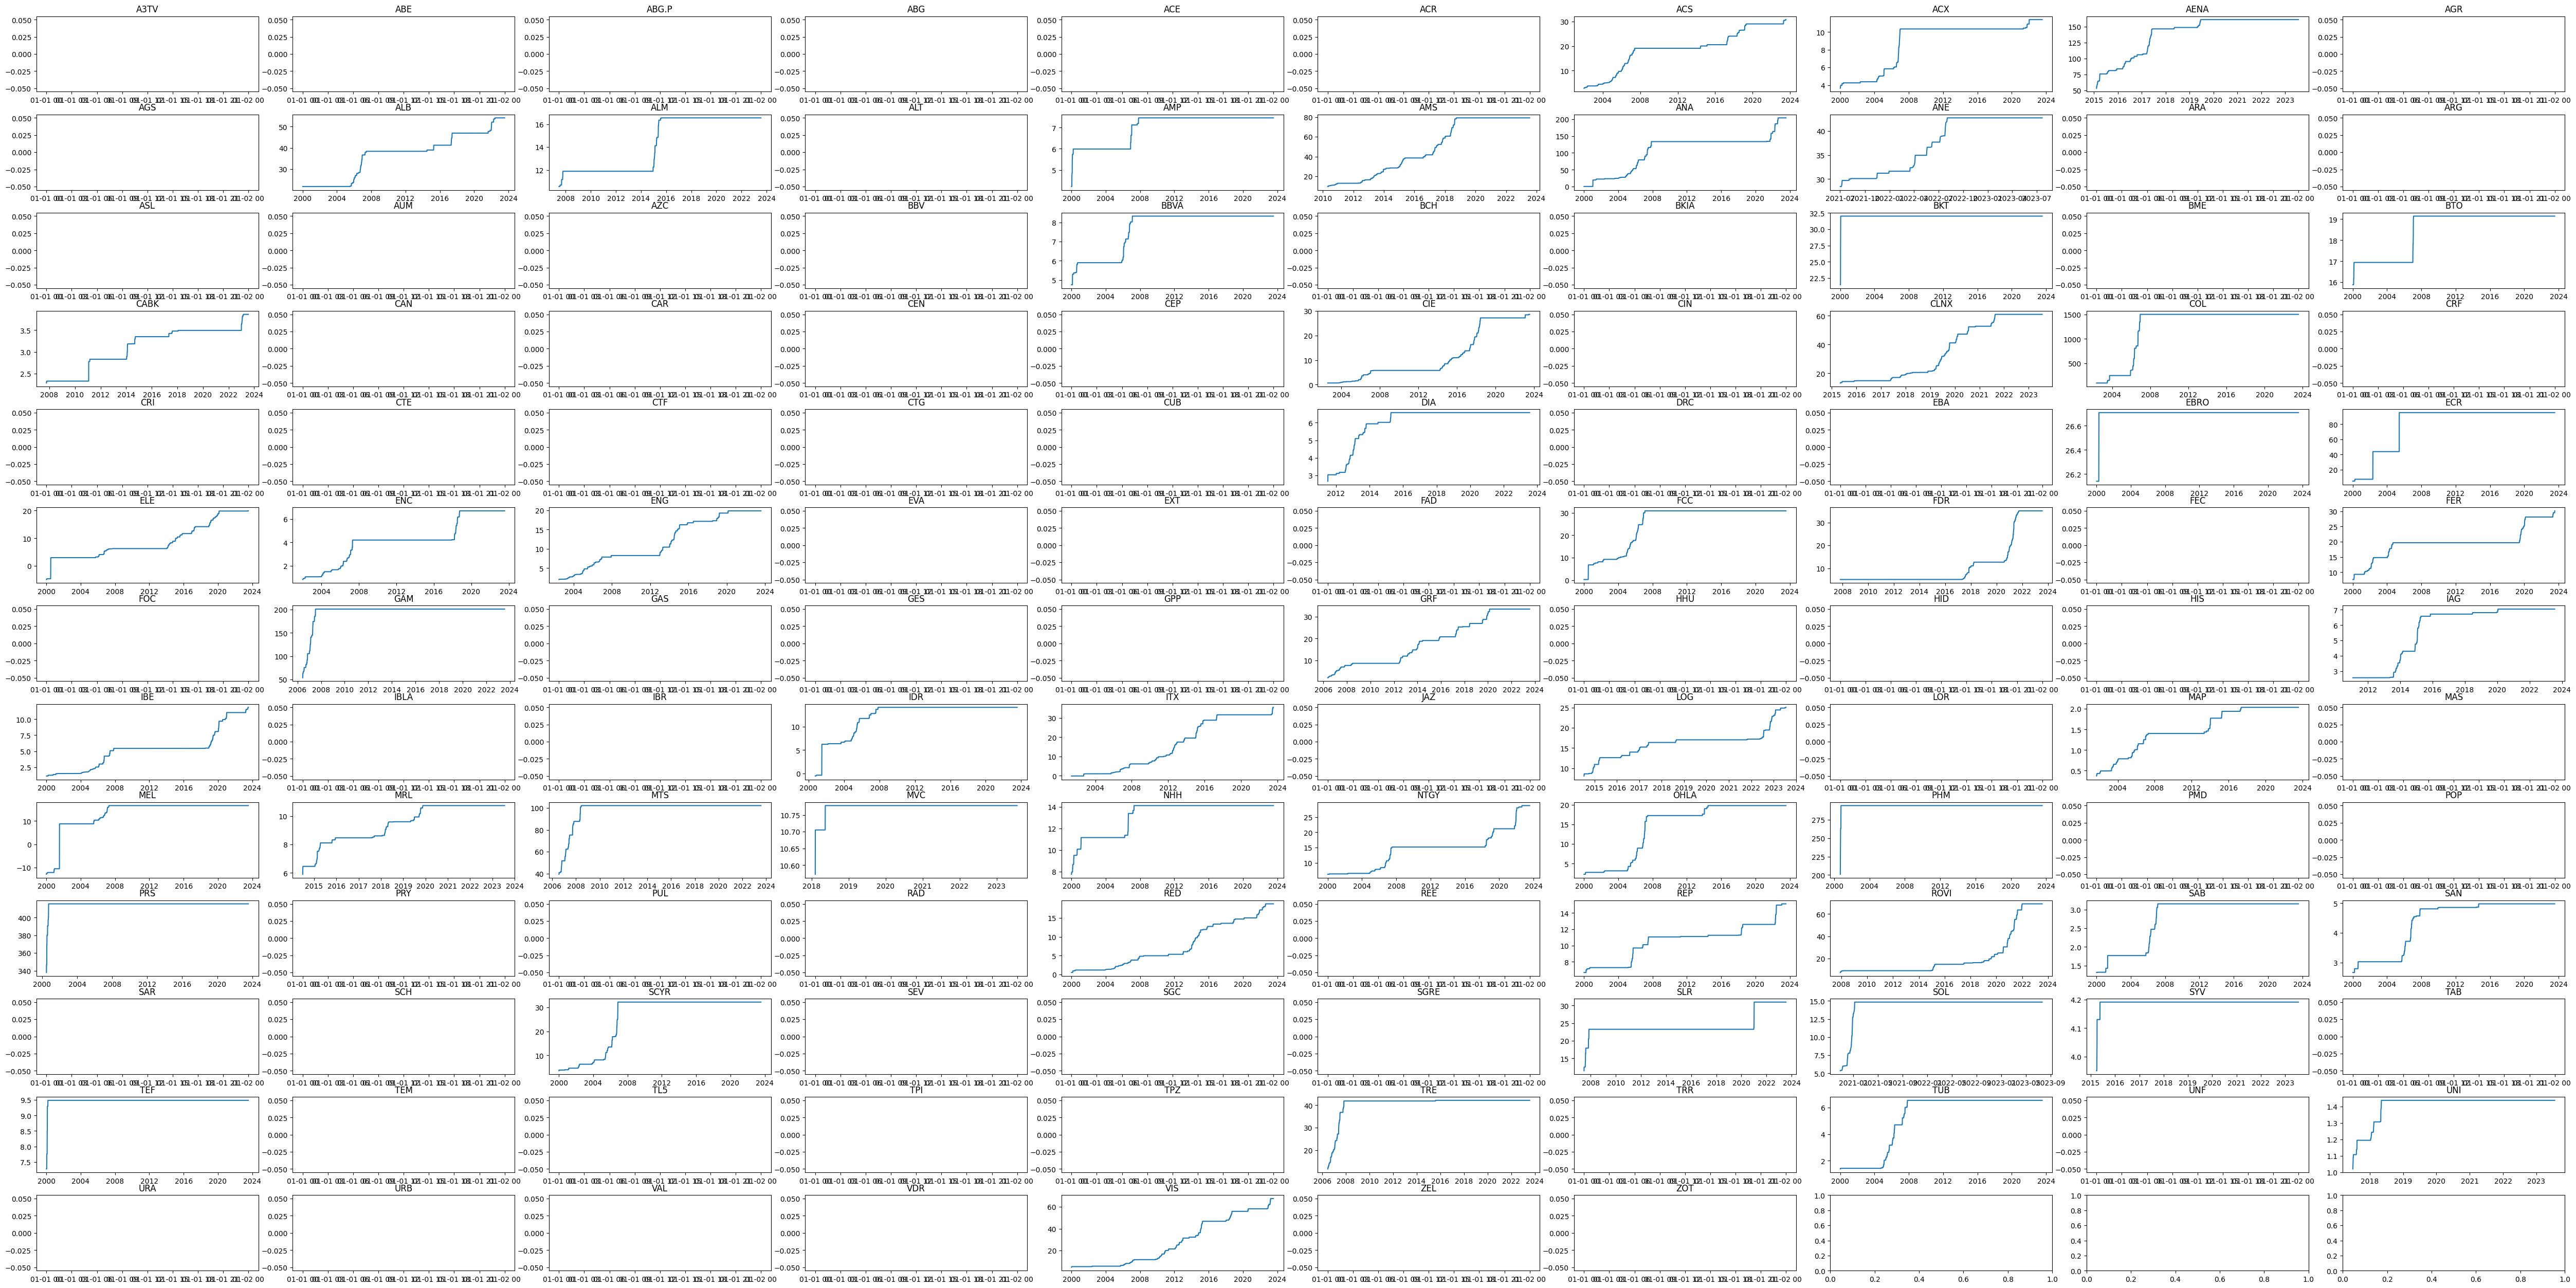

In [363]:
# GRAFICAMOS LA SERIE DE PRECIOS SOLAMENTE CON LOS MAXIMOS
fig, axs = plt.subplots(nrows=13,ncols=10, figsize=(50, 25),)
fig.tight_layout() 
axs = axs.ravel()

for i in range(len(ibex_max_rolling.columns)):

    axs[i].plot(ibex_max_rolling[act_list[i]])
    axs[i].set_title(act_list[i])

In [563]:
# CALCULAMOS EL INDICE DE TIEMPO BAJO EL AGUA
underwater_ibex = (ibex_historical_data / ibex_max_rolling)-1

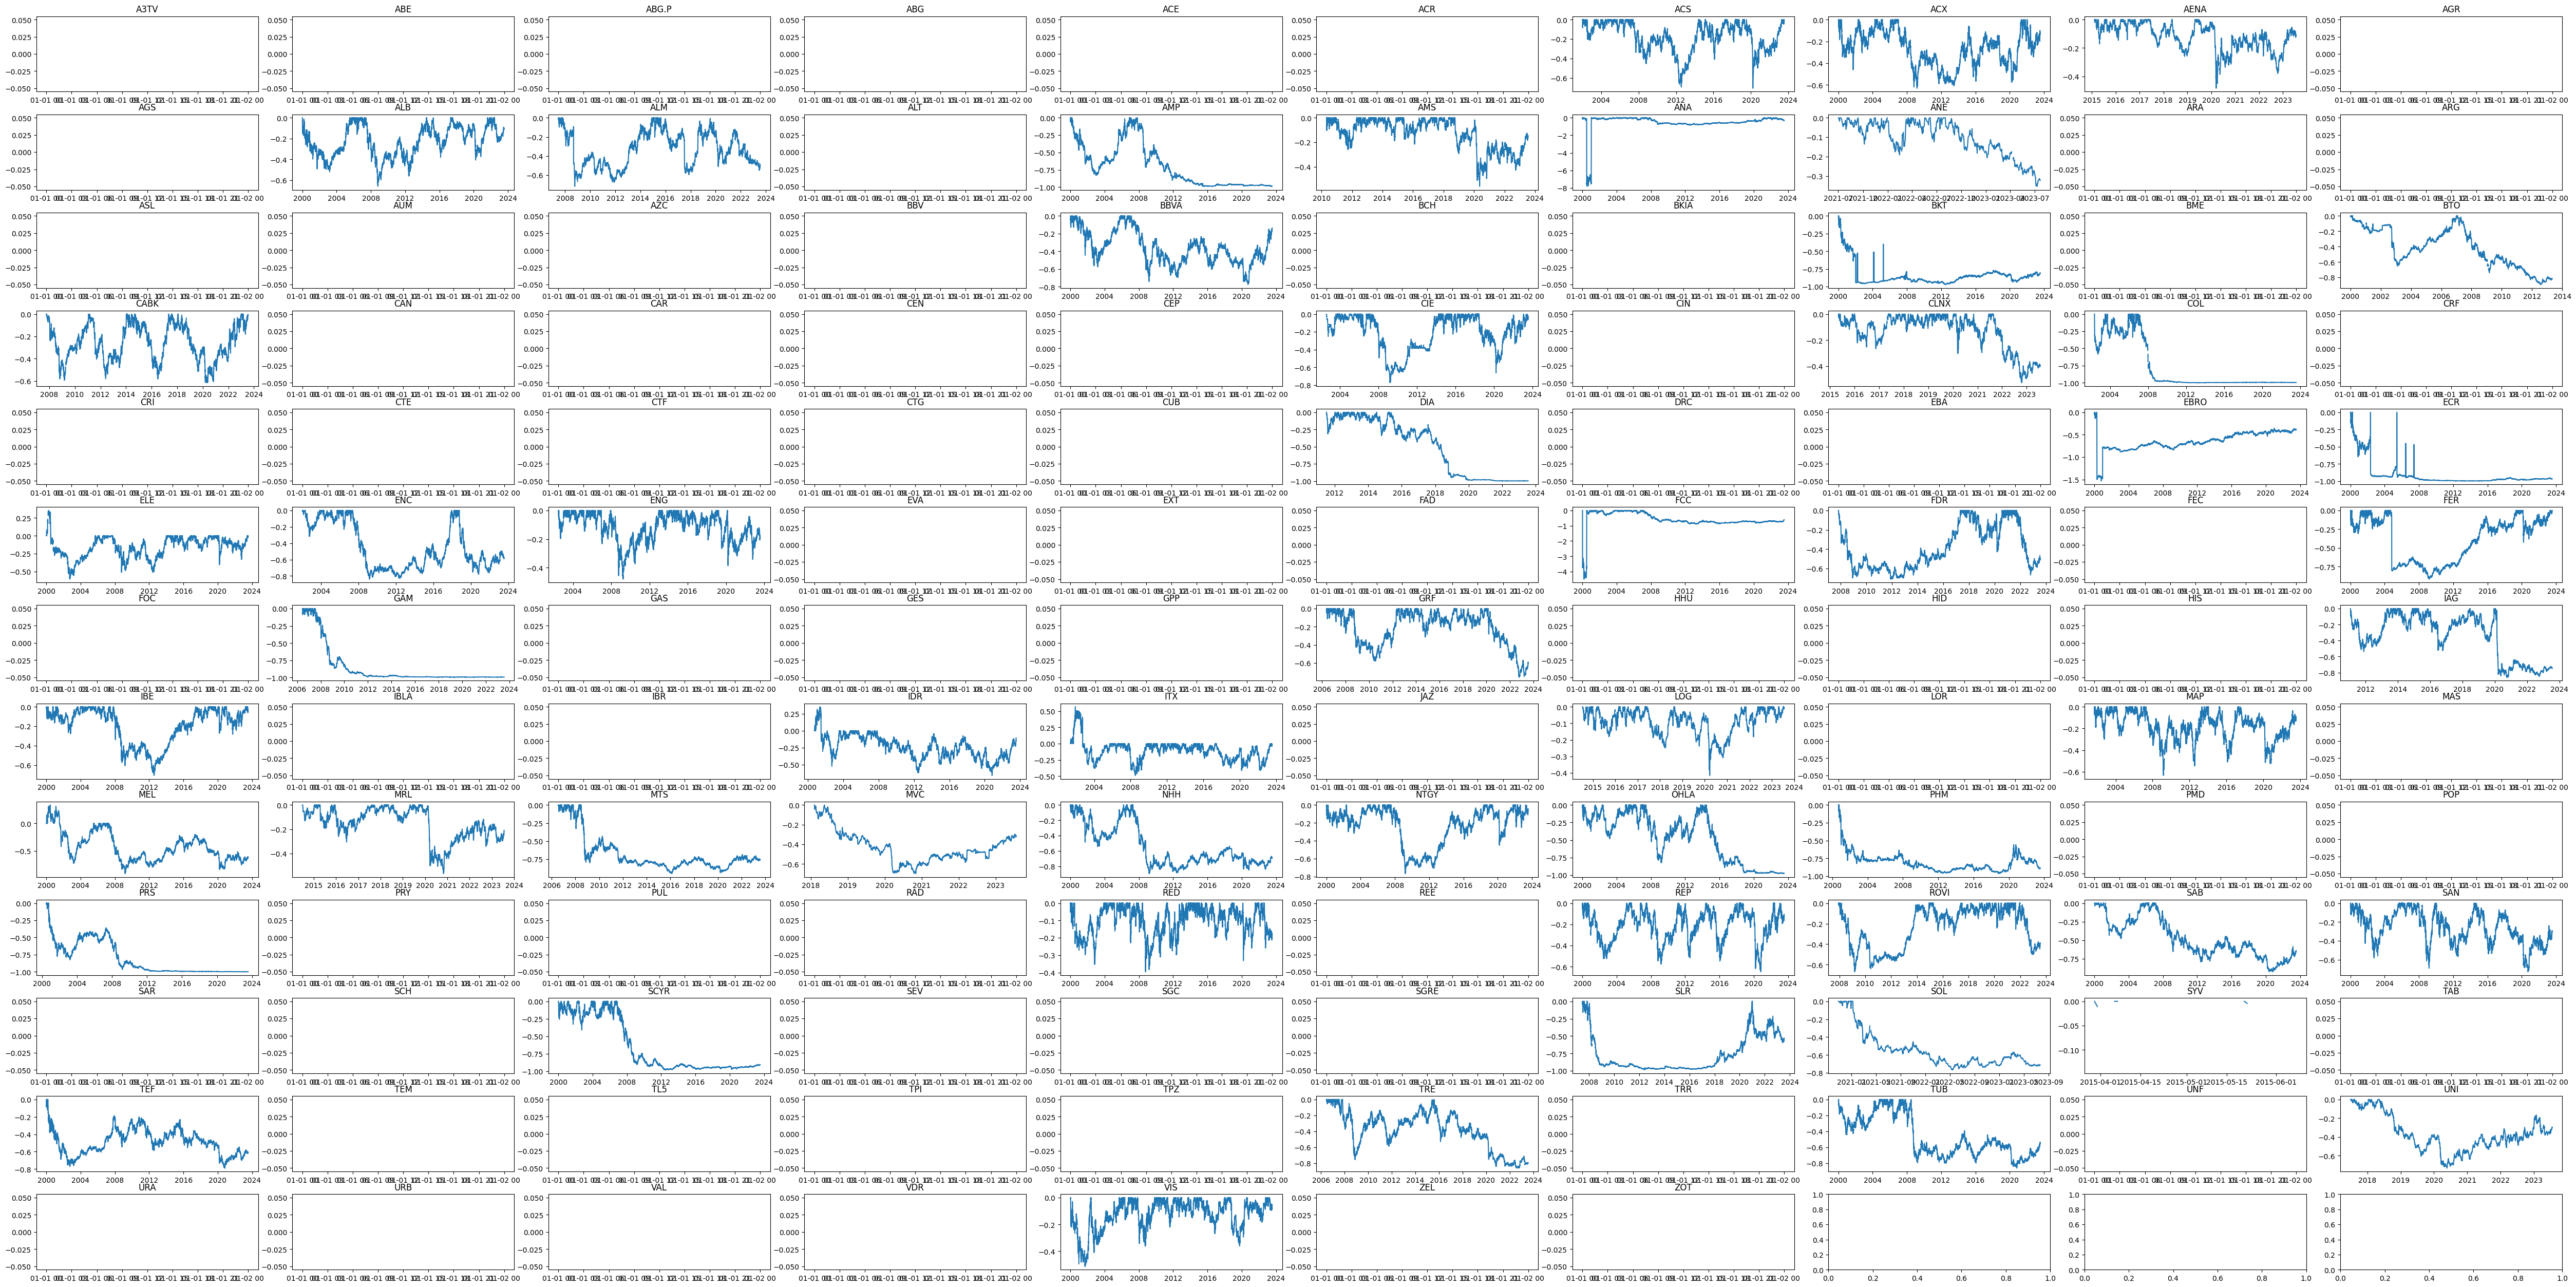

In [365]:
# GRAFICAMOS EL TIEMPO BAJO EL AGUA
fig, axs = plt.subplots(nrows=13,ncols=10, figsize=(50, 25),)
fig.tight_layout() 
axs = axs.ravel()

for i in range(len(underwater_ibex.columns)):

    axs[i].plot(underwater_ibex[act_list[i]])
    axs[i].set_title(act_list[i])

In [564]:
# CALCULAMOS LOS RETORNOS AL CIERRE DE TODOS LOS ACTIVOS
returns = np.log(ibex_historical_data).diff()
returns

,A3TV,ABE,ABG.P,ABG.P_1,ABG,ACE,ACR,ACS,ACX,ACX_1,...,URB,VAL,VAL_1,VDR,VIS,VIS_1,VIS_2,VIS_3,ZEL,ZOT
date,,,,,,,,,,,,,,,,,,,,,
1993-08-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-08-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.004065,...,NaN,NaN,NaN,NaN,-0.023535,NaN,NaN,NaN,NaN,-0.006083
1993-08-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,...,NaN,NaN,NaN,NaN,0.029290,NaN,NaN,NaN,NaN,0.002925
1993-08-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.054313,...,NaN,NaN,NaN,NaN,-0.002839,NaN,NaN,NaN,NaN,-0.000243
1993-08-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,...,NaN,NaN,NaN,NaN,-0.005841,NaN,NaN,NaN,NaN,0.005099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-07-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-07-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


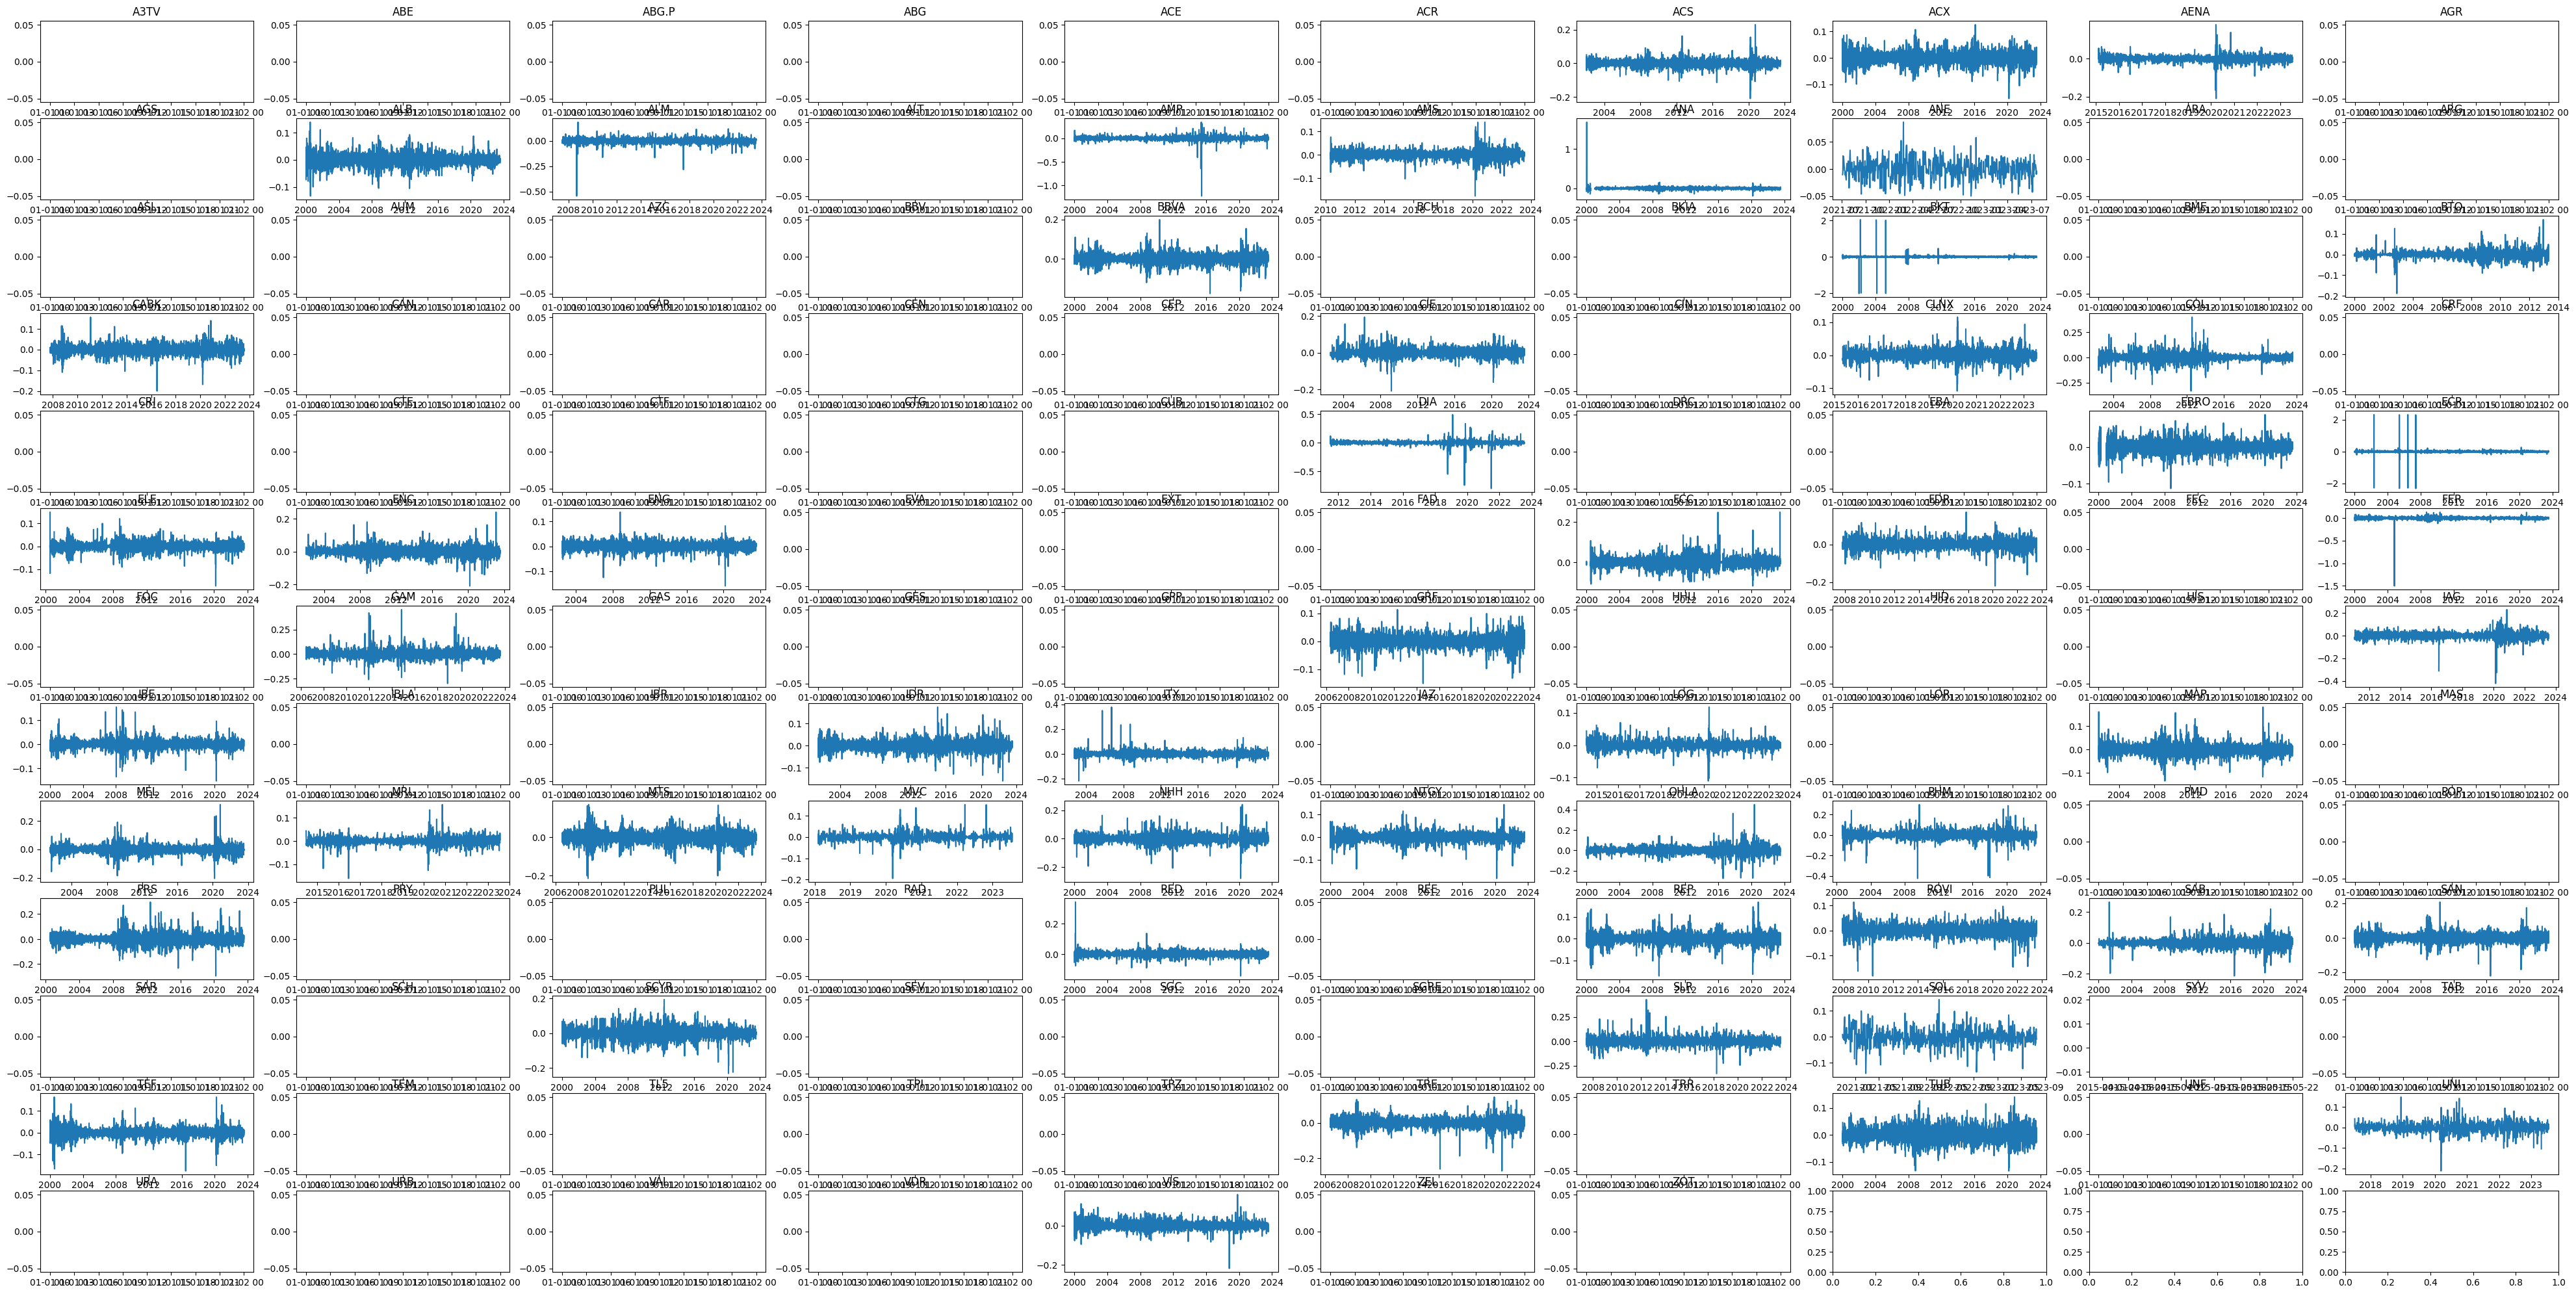

In [369]:
# GRAFICAMOS LOS RETORNOS DE TODOS LOS ACTIVOS
fig, axs = plt.subplots(nrows=13,ncols=10, figsize=(50, 25))

axs = axs.ravel()

for i in range(len(returns.columns)):

    axs[i].plot(returns[act_list[i]])
    axs[i].set_title(act_list[i])

In [801]:
# BUSCAMOS AQUELLOS ACTIVOS QUE NO TIENEN VALORES EN TODA LA SERIE HISTORICA
null_act = ibex_historical_data.columns[ibex_historical_data.isna().sum() == ibex_historical_data.shape[0]]
null_act, len(null_act)

(Index(['ABG.P', 'ACE', 'ACR', 'AGR', 'AGS_1', 'AGS_2', 'AGS_3', 'ALB', 'ALB_1',
        'ARA', 'ARG', 'ASL', 'AUM', 'AZC', 'AZC_1', 'BBV', 'BCH', 'BTO', 'CAN',
        'CEN', 'CEP', 'CEP_1', 'CRF', 'CRI_1', 'CRI_2', 'CTE', 'CTF', 'CTG',
        'CUB', 'EBA', 'ECR', 'EXT', 'FEC', 'FOC', 'GAM', 'GAM_1', 'GAS', 'GES',
        'GES_1', 'GPP', 'HHU', 'HHU_1', 'HID', 'HIS', 'LOG', 'MVC', 'MVC_1',
        'PMD', 'PRY', 'PUL', 'RAD', 'RED', 'SAR', 'SCH', 'SEV', 'SOL', 'SYV',
        'SYV_1', 'TAB', 'TPI', 'TPZ', 'TRR', 'TRR_1', 'URA', 'URB', 'VAL',
        'VAL_1', 'VDR'],
       dtype='object'),
 68)

In [568]:
# HACEMOS UN ANALISIS SOBRE ALGUNAS MÉTRICAS PARA TODOS LOS ACTIVOS
# CALCULAMOS LA BETA PARA CADA ACTIVO
# PARA ESTO NECESITAMOS TAMBIÉN OBTENER EL PRECIO DEL INDICE DE REFERENCIA 
ibex_index = yf.download('^IBEX')['Adj Close']
ibex_index

[*********************100%***********************]  1 of 1 completed


Date
1993-07-12    2826.396973
1993-07-13    2843.396973
1993-07-14    2851.097168
1993-07-15    2843.697021
1993-07-16    2830.497070
                 ...     
2023-07-31    9641.500000
2023-08-01    9502.900391
2023-08-02    9328.700195
2023-08-03    9307.099609
2023-08-04    9368.400391
Name: Adj Close, Length: 7614, dtype: float64

In [569]:
t_bill_files = [filename for filename in os.listdir('./Datos TFM') if filename.startswith("United States 3-Month Bond Yield")]
t_bill_data = pd.DataFrame()
for f in t_bill_files:
    file_path = './Datos TFM/'+f
    file = pd.read_csv(file_path)
    t_bill_data = pd.concat([t_bill_data,file],axis=0)
t_bill_data.index = pd.to_datetime(t_bill_data.Date)
t_bill_data.drop('Date',axis=1,inplace=True)
t_bill_data.head()

,Price,Open,High,Low,Change %
Date,,,,,
2023-07-25,5.436,5.432,5.439,5.426,0.34%
2023-07-24,5.418,5.453,5.486,5.418,-0.11%
2023-07-21,5.424,5.445,5.469,5.411,0.15%
2023-07-20,5.416,5.448,5.503,5.409,0.07%
2023-07-19,5.412,5.452,5.452,5.409,0.00%


In [403]:
file_name = 'risk_free_rate.parquet'
full_path = root_path + raw_folder + file_name
risk_free_rate.to_parquet(full_path)

PermissionError: The AWS Access Key Id you provided does not exist in our records.

In [231]:
def calculate_sharpe_ratio(returns, risk_free_rate):
    """
    Calcular el ratio de Sharpe

    Parámetros:
    returns (np.array): Array de rendimientos de la inversión
    risk_free_rate (float): Tasa de rendimiento sin riesgo

    Devuelve:
    sharpe_ratio (float): Ratio de Sharpe
    """

    # Calcular el rendimiento promedio
    avg_returns = np.mean(returns)

    # Calcular la desviación estándar de los rendimientos
    std_returns = np.std(returns)

    # Calcular el ratio de Sharpe
    sharpe_ratio = (avg_returns - risk_free_rate) / std_returns

    return sharpe_ratio

### SCRIPT PARA CALCULAR LA FRONTERA EFICIENTE DE MARKOWITZ

In [ ]:
# PARA HACER:
# - CALCULAR RETORNOS CADA "D" CANTIDAD DE DÍAS                                 DONE
# - CALCULAR RATIO DE SHARPE DE ESTOS RETORNOS                                  DONE
# - ORDENAR POR MAYOR RATIO DE SHARPE (U OTRA METRICA)                          DONE
# - TOMAR N CANTIDAD DE ACTIVOS                                                 DONE
# - SIMULAR N CARTERAS DE ACTIVOS                                               DONE
# - TOMAR MEJOR CARTERA POR RATIO DE SHARPE                                     DONE
# - SIMULAR EJECUCIÓN DE COMPRAS A PRECIO DE CIERRE DEL DIA SIGUIENTE
# - CALCULAR RETORNOS DIARIOS DE LA CARTERA
# - MONITORIZAR POR D CANTIDAD DE DÍAS, STOP LOSS O TAKE PROFIT
# - REPETIR PROCESO

In [737]:
# DEFINIMOS UNA CANTIDAD DE DIAS PARA LA VENTANA DE CALCULO DE LOS RETORNOS
DIAS = 10
ACTIVOS = 10

# CALCULAMOS LOS RETORNOS AL CIERRE DE TODOS LOS ACTIVOS
returns = np.log(ibex_historical_data).diff()[1:]
returns.index = pd.to_datetime(returns.index)
# DEFINIMOS NUESTRA TASA LIBRE DE RIESGO A TRAVÉS DE LOS VALORES DE LA TASA T-BILLS DE 3 MESES
risk_free_rate = t_bill_data['Price']/100
risk_free_rate = risk_free_rate.sort_index()
returns['risk_free_rate'] = risk_free_rate.loc['05-08-1993':]
returns['risk_free_rate'] = returns['risk_free_rate'].fillna(method='ffill')
# AGREGAMOS LA OPCIÓN DE NO INVERTIR EN NINGUN ACTIVO COMO UNA COLUMNA CON RETORNO CERO
returns['cash'] = 0

# CALCULAMOS LA SUMA DE RETORNOS CON ESA VENTANA DE DIAS DEFINIDA
adjusted_returns = (returns.transpose() - returns['risk_free_rate']).transpose()
adjusted_period_returns_mean = adjusted_returns.rolling(DIAS, min_periods=0).mean()
adjusted_period_returns_std = adjusted_returns.rolling(DIAS, min_periods=0).std()

sharpe_ratio = adjusted_period_returns_mean / adjusted_period_returns_std
sharpe_ratio.drop('risk_free_rate',axis=1)

,A3TV,ABE,ABG.P,ABG.P_1,ABG,ACE,ACR,ACS,ACX,ACX_1,...,VAL,VAL_1,VDR,VIS,VIS_1,VIS_2,VIS_3,ZEL,ZOT,cash
date,,,,,,,,,,,,,,,,,,,,,
1993-08-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-08-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-10.945992,...,NaN,NaN,NaN,-0.751384,NaN,NaN,NaN,NaN,-5.006631,-209.135248
1993-08-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.675936,...,NaN,NaN,NaN,-1.122776,NaN,NaN,NaN,NaN,-6.816793,-147.380952
1993-08-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.722195,...,NaN,NaN,NaN,-1.435250,NaN,NaN,NaN,NaN,-6.129745,-174.464541
1993-08-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.060611,...,NaN,NaN,NaN,-1.568130,NaN,NaN,NaN,NaN,-2.992507,-190.453635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-185.969497
2023-07-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-161.814989
2023-07-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-163.603285


In [803]:
ACTIVOS = 10
DIAS = 10
PORTFOLIOS = 10000
# ranking = np.argsort(-sharpe_ratio).drop('Price',axis=1)

# SIMULACION DE ACTIVIDAD DE MERCADO
# PARA CADA DIA DEBO ANALIZAR EL RANKING DADO
for i in sharpe_ratio.index[1:2]:
    
    # DEBO TOMAR A CANTIDAD DE ACTIVOS CON MAYOR RATIO DE SHARPE
    truncated_ranking = sharpe_ratio.loc[i].sort_values(ascending=True,na_position='last')[:ACTIVOS].index
    simulacion = pd.DataFrame(columns=['r_p', 'std_p', *truncated_ranking], index=range(PORTFOLIOS))
    # DEBO SIMULAR P CANTIDAD DE PORTFOLIOS
    for p in range(PORTFOLIOS):
        # DEBO CALCULAR EL RATIO DE SHARPE DE CADA PORTFOLIO
        w = np.random.rand(1,len(truncated_ranking))
        w = w / w.sum()
        w_transposed = w.T

        ret = adjusted_period_returns_mean.loc[i,truncated_ranking]
        sigma = adjusted_returns.loc[i-datetime.timedelta(days=10):i,truncated_ranking].cov()#.fillna(0)
        
        r_p = ret @ w_transposed
        s_p = np.sqrt(w @ sigma @ w_transposed)
        # r_p = np.dot(w,ret)
        # s_p = np.sqrt(np.dot(np.dot(w,sigma),w_transposed))
        simulacion.loc[p,"r_p"] = r_p[0]
        simulacion.loc[p,"std_p"] = s_p[0][0]
        simulacion.iloc[p,2:] = w
        # print(simulacion.iloc[p])
    simulacion['sharpe'] = simulacion.loc[:, 'r_p'] / simulacion.loc[:, 'std_p']
    r_port_sharpe = simulacion.iloc[np.argmax(simulacion.sharpe)]
    r_port_maxrent = simulacion.iloc[np.argmax(simulacion.r_p)]
    r_port_minrisk = simulacion.iloc[np.argmin(simulacion.std_p)]
    print(r_port_sharpe,r_port_maxrent,r_port_minrisk)
    

r_p      -0.034396
std_p      0.00674
cash      0.043569
IBE       0.019721
BKT       0.002013
ACX_1     0.016426
TEF       0.249859
SAN       0.024544
ZOT       0.198993
REP       0.012095
FCC       0.199112
MAP       0.233669
sharpe   -5.103343
Name: 9889, dtype: object r_p        -0.026975
std_p       0.000133
cash         0.19227
IBE          0.01002
BKT         0.029745
ACX_1        0.20247
TEF         0.198086
SAN         0.004859
ZOT         0.015894
REP         0.336649
FCC         0.006202
MAP         0.003805
sharpe   -202.736416
Name: 9541, dtype: object r_p         -0.030433
std_p        0.000014
cash          0.02599
IBE          0.199406
BKT          0.097651
ACX_1        0.134197
TEF          0.118783
SAN           0.20311
ZOT          0.002669
REP           0.21063
FCC          0.003158
MAP          0.004405
sharpe   -2165.007031
Name: 4166, dtype: object


C:\Users\aleja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


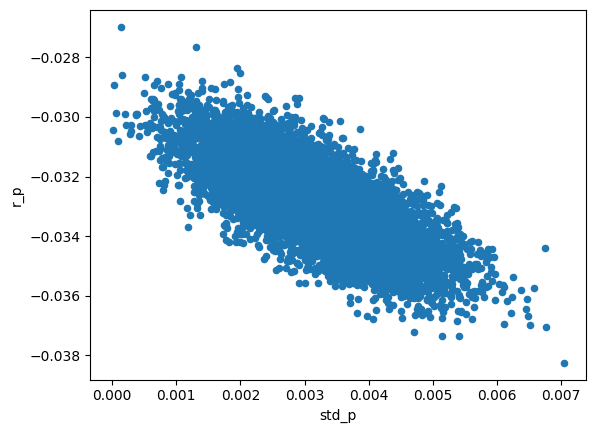

In [806]:
simulacion.plot.scatter(x='std_p',y='r_p');

### SCRIPT PARA CALCULAR LA FRONTERA EFICIENTE DE MARKOWITZ

In [ ]:
portfolios = 10000
simulacion = pd.DataFrame(columns=["retorno_portfolio","desv_tip_portfolio",df.columns],index=range(portfolios))

for portfolio in range(portfolios):
    w = random.rand(1,df.shape[1])
    w = w / w.sum()
    retornos = df.pct_change()
    mu = retornos.mean()
    sigma = retornos.cov()
    w_transposed = w.T
    r_p = np.dot(w,mu)
    s_p = np.sqrt(np.dot(np.dot(w,sigma),w_transposed))
    simulacion.loc[portfolio,"retorno_portfolio"] = r_p
    simulacion.loc[portfolio,"desv_tip_portfolio"] = s_p
    simulacion.iloc[portfolio,2:] = w

In [ ]:
simulacion.plot.scatter(x="desv_tip_portfolio",y="retorno_portfolio")
plt.show()

### SCRIPT PARA HACER BACKTESTING

In [ ]:
# DEFINIR PRECIO DE COMPRA 

In [921]:
# DEFINIMOS NUESTRO CAPITAL INICIAL
INIT_CAPITAL = 100_000

In [922]:
# DEFINIMOS UN DATAFRAME INICIAL PARA GUARDAR LOS PESOS DE NUESTRAS CARTERAS DE INVERSION
portfolio_weights = np.zeros(ibex_historical_data.shape[1])
portfolio_weights = pd.DataFrame(portfolio_weights).T
portfolio_weights.columns=ibex_historical_data.columns
portfolio_weights

,A3TV,ABE,ABG.P,ABG.P_1,ABG,ACE,ACR,ACS,ACX,ACX_1,...,URB,VAL,VAL_1,VDR,VIS,VIS_1,VIS_2,VIS_3,ZEL,ZOT
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [923]:
# GUARDAMOS LOS PESOS DE NUESTRA CARTERA
portfolio_weights[r_port_sharpe[2:-1].index] = r_port_sharpe[2:-1]

# CALCULAMOS LOS VALORES DE CADA ACTIVO DE NUESTRA CARTERA Y LE QUITAMOS EL PORCENTAJE DE COMISION
portfolio_allocations = portfolio_weights.iloc[:,:-1] * INIT_CAPITAL * (1-0.002)
portfolio_allocations['cash'] = portfolio_weights['cash'] * INIT_CAPITAL
portfolio_allocations

,A3TV,ABE,ABG.P,ABG.P_1,ABG,ACE,ACR,ACS,ACX,ACX_1,...,VAL,VAL_1,VDR,VIS,VIS_1,VIS_2,VIS_3,ZEL,ZOT,cash
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1639.362614,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19859.476973,4356.853273


In [924]:
portfolio_weights

,A3TV,ABE,ABG.P,ABG.P_1,ABG,ACE,ACR,ACS,ACX,ACX_1,...,VAL,VAL_1,VDR,VIS,VIS_1,VIS_2,VIS_3,ZEL,ZOT,cash
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.016426,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.198993,0.043569


In [925]:
# CALCULAMOS LA CANTIDAD DE VALORES DE CADA ACTIVO QUE SE COMPRARAN A PRECIO DE CIERRE DEL DIA SIGUIENTE
allocations = portfolio_allocations.iloc[:,:-1].divide(ibex_historical_data.loc[ibex_historical_data.index[2]].dropna()).dropna(axis=1)
num_valores = allocations.apply(lambda x: math.floor(x))

# CALCULAMOS EL EXCESO DE VALORES PARCIALES (DECIMALES) QUE NO PUEDEN COMPRARSE Y DESTINAMOS ESE MONTO AL CASH QUE NO SE INVERTIRÁ EN NINGUN ACTIVO
excess = allocations.apply(lambda x: x%1)
portfolio_allocations['cash'] += excess.dot(ibex_historical_data.loc[ibex_historical_data.index[2]].dropna())
# RECALCULAMOS LOS PESOS DE NUESTRA CARTERA
portfolio_weights = portfolio_allocations/portfolio_allocations.sum().sum()
portfolio_allocations = portfolio_weights.iloc[:,:-1] * INIT_CAPITAL * (1-0.002)
portfolio_allocations['cash'] = portfolio_weights['cash'] * INIT_CAPITAL
portfolio_allocations

,A3TV,ABE,ABG.P,ABG.P_1,ABG,ACE,ACR,ACS,ACX,ACX_1,...,VAL,VAL_1,VDR,VIS,VIS_1,VIS_2,VIS_3,ZEL,ZOT,cash
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1639.093111,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19856.21217,4372.576549


In [1033]:
# CALCULAMOS EL RETORNO DIARIO DESDE LA COMPRA DE LOS ACTIVOS
next_allocation = num_valores[num_valores!=0] * ibex_historical_data.loc[ibex_historical_data.index[12]].dropna()
# portfolio_allocations[portfolio_allocations!=0].dropna(axis=1)

In [1034]:
(1 - portfolio_allocations[portfolio_allocations!=0].dropna(axis=1).iloc[0,:-1]/next_allocation)

ACX_1    0.028129
ALB_2         NaN
BKT      0.078681
FCC      0.132028
IBE      0.098019
MAP      0.049615
REP      0.038318
SAN      0.038516
TEF      0.102840
VIS           NaN
ZOT      0.077183
dtype: float64

In [1036]:
(next_allocation.dropna() - portfolio_allocations[portfolio_allocations!=0].dropna(axis=1).iloc[0,:-1]).sum()

9182.680995596056

In [1037]:
# CALCULAMOS EL PORCENTAJE DE VARIACIÓN DE LA CARTERA
(next_allocation.dropna() - portfolio_allocations[portfolio_allocations!=0].dropna(axis=1).iloc[0,:-1]).sum()/portfolio_allocations[portfolio_allocations!=0].dropna(axis=1).iloc[0,:-1].sum().sum()

0.09621803902941174

In [ ]:
delta_cash = pd.Series(0, index=stock_df.index)
delta_cash.iloc[0] = init_capital
delta_shares = pd.DataFrame(0, index=stock_df.index, columns=stock_df.columns)

for idate, isignals in all_signals.iterrows():    
    daybuys = isignals[isignals == 1]
    daysells = isignals[isignals == -1]
    
    if daybuys.count() == 0 and daysells.count() == 0:
        continue

    # actualizar portfolio 
    cash = delta_cash.cumsum()
    posiciones = delta_shares.cumsum()
    valoracion = posiciones * stock_df
    inversiones = valoracion.sum(axis=1)
    equity = inversiones + cash
    
    day_cash = cash.loc[idate]
    # limite de asignación a un 10% de la cartera
    alloc_limit = equity.loc[idate] * 0.1

    in_money, out_money = 0, 0
    # compras
    if daybuys.count() > 0:
        tk_money = min(day_cash/daybuys.count(), alloc_limit)
        buy_shares = np.floor(tk_money/open_df.loc[idate, daybuys.index])
        out_money = (buy_shares * open_df.loc[idate, daybuys.index]).sum()
        delta_shares.loc[idate, daybuys.index] = buy_shares

    # ventas
    if daysells.count() > 0:
        sell_shares = posiciones.loc[idate, daysells.index]
        in_money = (sell_shares * open_df.loc[idate, daysells.index]).sum()
        delta_shares.loc[idate, daysells.index] = -sell_shares

    delta_cash.loc[idate] = in_money - out_money

In [ ]:
# ultima actualizacion
cash = delta_cash.cumsum()
posiciones = delta_shares.cumsum()
valoracion = posiciones * stock_df
inversiones = valoracion.sum(axis=1)
equity = inversiones + cash

In [ ]:
show_df = pd.DataFrame({
    'inversiones': inversiones,
    'efectivo': cash,
    'patrimonio': equity
})
show_df.plot(figsize=(10,6))

In [ ]:
show_df.tail()

In [ ]:
bm = benchmark.reindex(stock_df.index)
pasive_invest = init_capital*(bm/bm.iloc[0])

In [ ]:
compare_df = pd.DataFrame({
    'SMA': equity,
    'benchmark': pasive_invest
})

compare_df.plot(figsize=(10,6))

## SOLO PARA TESTEAR WEBSCRAPING DE INVESTING

In [63]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
import time

In [79]:
driver = webdriver.Chrome()
driver.get('https://www.investing.com/')
time.sleep(1)
button = driver.find_element(By.ID,'onetrust-accept-btn-handler')
button.click()
input = driver.find_element(By.CSS_SELECTOR,'body > div.wrapper > header > div.topBar > div > div.searchDiv.newSearchDiv.js-main-search-wrapper > div.searchBoxContainer.topBarSearch.topBarInputSelected > input')
input.send_keys('ACX')
time.sleep(1)
first_selection = driver.find_element(By.CLASS_NAME,"row.js-quote-row-template.js-quote-item")
first_selection.click()
driver.maximize_window()
html = driver.find_element(By.TAG_NAME, 'html')
html.send_keys(Keys.PAGE_DOWN)
time.sleep(1)
historical_data = driver.find_element(By.XPATH,'//*[@id="__next"]/div[2]/div/div/div[2]/main/div[1]/div[7]/nav/ul/li[3]/a')
historical_data.click()
start_date = ibex_constituents.loc[ibex_constituents['Activo']=='ACX']['Inclusion']
end_date = ibex_constituents.loc[ibex_constituents['Activo']=='ACX']['Exclusion']
html = driver.find_element(By.TAG_NAME, 'html')
html.send_keys(Keys.PAGE_DOWN)
date_entry = driver.find_element(By.CLASS_NAME,"DatePickerWrapper_input-text__PDRoD.DatePickerWrapper_center__zPpJy")
date_entry.click()
start_date_entry = driver.find_element(By.XPATH,'NativeDateInput_root__wbgyP')
start_date_entry.send_keys(start_date)
end_date_entry = driver.find_element(By.CLASS_NAME,"NativeDateInput_root__wbgyP")
end_date_entry.send_keys(end_date)

# Obtain the number of rows in body
rows = 1+len(driver.find_elements(By.XPATH,
    "//*[@id=\"__next\"]/div[2]/div/div/div[2]/main/div/div[8]/div/div/div[3]/div/table"))
 
# Obtain the number of columns in table
cols = len(driver.find_elements(By.XPATH,
    "//*[@id=\"__next\"]/div[2]/div/div/div[2]/main/div/div[8]/div/div/div[3]/div/table"))
 
# Print rows and columns
print(rows)
print(cols)
 
# Printing the table headers
print("Locators           "+"             Description")
 
# Printing the data of the table
for r in range(2, rows+1):
    for p in range(1, cols+1):
       
        # obtaining the text from each column of the table
        value = driver.find_element(By.XPATH,
            "//*[@id=\"__next\"]/div[2]/div/div/div[2]/main/div/div[8]/div/div/div[3]/div/table/tbody/tr["+str(r)+"]/td["+str(p)+"]").text
        print(value, end='       ')
    print()

ElementClickInterceptedException: Message: element click intercepted: Element <div class="DatePickerWrapper_input-text__PDRoD DatePickerWrapper_center__zPpJy">...</div> is not clickable at point (821, 370). Other element would receive the click: <td class="datatable_cell__0y0eu datatable_cell--align-end__fwomz datatable_cell--up__Gt_ed font-bold" dir="ltr">...</td>
  (Session info: chrome=112.0.5615.121)
Stacktrace:
Backtrace:
	GetHandleVerifier [0x0053DCE3+50899]
	(No symbol) [0x004CE111]
	(No symbol) [0x003D5588]
	(No symbol) [0x00405A7A]
	(No symbol) [0x00404336]
	(No symbol) [0x0040267B]
	(No symbol) [0x00401797]
	(No symbol) [0x003F94A5]
	(No symbol) [0x0041B8FC]
	(No symbol) [0x003F8EC6]
	(No symbol) [0x0041BC54]
	(No symbol) [0x0042E01C]
	(No symbol) [0x0041B6F6]
	(No symbol) [0x003F7708]
	(No symbol) [0x003F886D]
	GetHandleVerifier [0x007A3EAE+2566302]
	GetHandleVerifier [0x007D92B1+2784417]
	GetHandleVerifier [0x007D327C+2759788]
	GetHandleVerifier [0x005D5740+672048]
	(No symbol) [0x004D8872]
	(No symbol) [0x004D41C8]
	(No symbol) [0x004D42AB]
	(No symbol) [0x004C71B7]
	BaseThreadInitThunk [0x75A57D59+25]
	RtlInitializeExceptionChain [0x77BCB74B+107]
	RtlClearBits [0x77BCB6CF+191]


In [47]:
import json
import datetime
import requests 
from bs4 import BeautifulSoup


url = 'https://www.investing.com/'
headers = {
    'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:81.0) Gecko/20100101 Firefox/81.0',
    'X-Requested-With': 'XMLHttpRequest',
    'Referer': 'https://www.investing.com/'}
data = requests.get(url, headers=headers).json()

# uncomment this to print all data:
# print( json.dumps(data, indent=4) )

for candle in data['candles']:
    t = datetime.datetime.fromtimestamp(candle[0] // 1000)
    print('{!s:<20} {:<10} {:<10} {:<10}'.format(t, *candle[1:]))

JSONDecodeError: Expecting value: line 1 column 1 (char 0)